The most commonly used object in the BeautifulSoup library is, appropriately, the
BeautifulSoup object. Let’s take a look at it in action, modifying the example found
in the beginning of this chapter:

In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen('http://www.pythonscraping.com/pages/page1.html')
bs = BeautifulSoup(html.read(), 'html.parser')
print(bs.h1)

<h1>An Interesting Title</h1>


Note that this returns only the first instance of the h1 tag found on the page. By convention,
only one h1 tag should be used on a single page, but conventions are often
broken on the web, so you should be aware that this will retrieve only the first
instance of the tag, and not necessarily the one that you’re looking for.

As in previous web scraping examples, you are importing the urlopen function and
calling html.read() to get the HTML content of the page. In addition to the text
string, BeautifulSoup can use the file object directly returned by urlopen, without
needing to call .read() first:

In [2]:
bs = BeautifulSoup(html, 'html.parser')

This HTML content is then transformed into a BeautifulSoup object with the following structure:

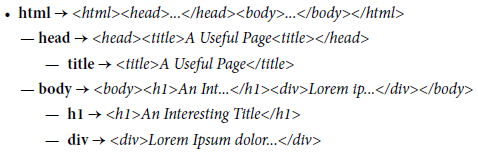

Note that the h1 tag that you extract from the page is nested two layers deep into your
BeautifulSoup object structure (html → body → h1). However, when you actually
fetch it from the object, you call the h1 tag directly:

In [3]:
bs.h1

In fact, any of the following function calls would produce the same output:

```
bs.html.body.h1
bs.body.h1
bs.html.h1
```

When you create a BeautifulSoup object, two arguments are passed in:

In [4]:
bs = BeautifulSoup(html.read(), 'html.parser')

The first is the HTML string that the object is based on, and the second specifies the
parser that you want BeautifulSoup to use to create that object. In the majority of
cases, it makes no difference which parser you choose.

html.parser is a parser that is included with Python 3 and requires no extra installations
to use. Except where required, we will use this parser throughout the book.

Another popular parser is lxml. This can be installed through pip:

`$ pip install lxml`

In [5]:
bs = BeautifulSoup(html.read(), 'lxml')

lxml has some advantages over html.parser in that it is generally better at parsing
“messy” or malformed HTML code. It is forgiving and fixes problems like unclosed
tags, tags that are improperly nested, and missing head or body tags.

lxml is also somewhat faster than html.parser, although speed is not necessarily
an advantage in web scraping, given that the speed of the network itself will almost
always be your largest bottleneck.

### Avoid Over-Optimizing Web Scraping Code

Elegant algorithms are lovely to behold, but when it comes to web
scraping, they may not have a practical impact. A few microseconds
of processing time will likely be dwarfed by the—sometimes
actual—seconds of network latency that a network request
takes.

Good web scraping code generally focuses on robust and easily
readable implementations, rather than clever processing optimizations.

Another popular HTML parser is html5lib. Like lxml, html5lib is an extremely forgiving
parser that takes even more initiative with correcting broken HTML. It also
depends on an external dependency and is slower than both lxml and html.parser.
Despite this, it may be a good choice if you are working with messy or handwritten
HTML sites.
It can be used by installing and passing the string html5lib to the BeautifulSoup
object:

`bs = BeautifulSoup(html.read(), 'html5lib')`

### Connecting reliably and Handling Exceptions

The web is messy. Data is poorly formatted, websites go down, and closing tags go
missing. One of the most frustrating experiences in web scraping is to go to sleep
with a scraper running, dreaming of all the data you’ll have in your database the next
day—only to find that the scraper hit an error on some unexpected data format and
stopped execution shortly after you stopped looking at the screen.

In situations like these, you might be tempted to curse the name of the developer who
created the website (and the oddly formatted data), but the person you should really
be kicking is yourself for not anticipating the exception in the first place!

Let’s look at the first line of our scraper, after the import statements, and figure out
how to handle any exceptions this might throw:

In [6]:
html = urlopen('http://www.pythonscraping.com/pages/page1.html')

Two main things can go wrong in this line:

- The page is not found on the server (or there was an error in retrieving it)
- The server is not found at all.

In the first situation, an HTTP error will be returned. This HTTP error may be “404
Page Not Found,” “500 Internal Server Error,” and so forth. In all of these cases, the
urlopen function will throw the generic exception HTTPError. You can handle this
exception in the following way:

In [7]:
from urllib.request import urlopen
from urllib.error import HTTPError

try:
    html = urlopen('http://www.pythonscraping.com/pages/page1.html')
except HTTPError as e:
    print(e)
    # return null, break, or do some other "Plan B"
else:
    # program continues. Note: If you return or break in the
    # exception catch, you do not need to use the "else" statement
    print("It Worked!")

It Worked!


If an HTTP error code is returned, the program now prints the error and does not
execute the rest of the program under the else statement.

If the server is not found at all (if, for example, http://www.pythonscraping.com is
down, or the URL is mistyped), urlopen will throw an URLError. This indicates that
no server could be reached at all, and, because the remote server is responsible for
returning HTTP status codes, an HTTPError cannot be thrown, and the more serious
URLError must be caught. You can add a check to see whether this is the case:

In [8]:
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError

try:
    html = urlopen('https://pythonscrapingthisurldoesnotexist.com')
except HTTPError as e:
    print(e)
except URLError as e:
    print('The server could not be found!')
else:
    print("It Worked!")

The server could not be found!


Of course, if the page is retrieved successfully from the server, there is still the issue of
the content on the page not being quite what you expected. Every time you access a
tag in a BeautifulSoup object, it’s smart to add a check to make sure the tag actually
exists. If you attempt to access a tag that does not exist, BeautifulSoup will return a
None object. The problem is, attempting to access a tag on a None object itself will
result in an AttributeError being thrown.

The following line (where nonExistentTag is a made-up tag, not the name of a real
BeautifulSoup function):

In [9]:
print(bs.nonExistentTag)

None


/tmp/ipykernel_21870/2784940019.py:1: DeprecationWarning: .nonExistentTag is deprecated, use .find("nonExistent") instead. If you really were looking for a tag called nonExistentTag, use .find("nonExistentTag")
  print(bs.nonExistentTag)


returns a None object. This object is perfectly reasonable to handle and check for. The
trouble comes if you don’t check for it but instead go on and try to call another function
on the None object, as illustrated here:

In [10]:
print(bs.nonExistentTag.someTag)

# This returns an exception:

/tmp/ipykernel_21870/3493111506.py:1: DeprecationWarning: .nonExistentTag is deprecated, use .find("nonExistent") instead. If you really were looking for a tag called nonExistentTag, use .find("nonExistentTag")
  print(bs.nonExistentTag.someTag)


AttributeError: 'NoneType' object has no attribute 'someTag'

So how can you guard against these two situations? The easiest way is to explicitly
check for both situations:

In [11]:
try:
    badContent = bs.nonExistingTag.anotherTag
except AttributeError as e:
    print('Tag was not found')
else:
    if badContent == None:
        print('Tag was not found')
    else:
        print(badContent)

Tag was not found


/tmp/ipykernel_21870/2524236393.py:2: DeprecationWarning: .nonExistingTag is deprecated, use .find("nonExisting") instead. If you really were looking for a tag called nonExistingTag, use .find("nonExistingTag")
  badContent = bs.nonExistingTag.anotherTag


This checking and handling of every error does seem laborious at first, but it’s easy to
add a little reorganization to this code to make it less difficult to write (and, more
important, much less difficult to read). This code, for example, is our same scraper
written in a slightly different way:

In [12]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup

def getTitle(url):
    try:
        html = urlopen(url)
    except HTTPError as e:
        return None
    try:
        bs = BeautifulSoup(html.read(), 'html.parser')
        title = bs.body.h1
    except AttributeError as e:
        return None
    return title

title = getTitle('http://www.pythonscraping.com/pages/page1.html')
if title == None:
    print('Title could not be found')
else:
    print(title)

<h1>An Interesting Title</h1>


In this example, you’re creating a function getTitle, which returns either the title of
the page, or a None object if there was a problem retrieving it. Inside getTitle, you
check for an HTTPError, as in the previous example, and encapsulate two of the BeautifulSoup
lines inside one try statement. An AttributeError might be thrown from
either of these lines (if the server did not exist, html would be a None object, and
html.read() would throw an AttributeError). You could, in fact, encompass as
many lines as you want inside one try statement or call another function entirely,
which can throw an AttributeError at any point.

When writing scrapers, it’s important to think about the overall pattern of your code
in order to handle exceptions and make it readable at the same time. You’ll also likely
want to heavily reuse code. Having generic functions such as getSiteHTML and
getTitle (complete with thorough exception handling) makes it easy to quickly—
and reliably—scrape the web.